### Sistema di retrieval implementato, basato su **autoencoder**

Metriche, salvare il valore della Loss, ricostruire l'immagine con l'autoencoder.

### Import

In [ ]:
# dim (1024, 768, 3)

In [ ]:
'''
im=cv2.imread('/content/drive/MyDrive/Computer Vision Project/Code/Dataset/Dataset-mezzo/images/11619237ej_0_e.jpg')
im.shape
'''

(1024, 768, 3)

In [ ]:
# Additional Dependencies
!pip install barbar torchsummary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Content Based Image Retrieval (CBIR)


In [ ]:
import time
import copy
import pickle
from barbar import Bar
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torchvision.utils import save_image
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms, models
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0
import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

print(device)

cpu


## Pre-processing 2

In [ ]:
path= '/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/dati-triplet.csv'

In [ ]:
df = pd.read_csv(path)
df.shape

(15367, 2)

In [ ]:
# reduce dimension of the dataset
df, df_cut= train_test_split(df, test_size=0.4) #, shuffle=False
df.shape
# trainDF, testDF= train_test_split(df, test_size=0.4)

(9220, 2)

In [ ]:
df.shape

(9220, 2)

# Data Preparation

In [ ]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            # RESIZE
            transforms.Resize((512, 512))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = self.transformations(Image.open(row['image_path'])) # 'image_path'
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)

In [ ]:
# Intermediate Function to process data from the data retrival class
def prepare_data(DF):
    DF, _ = train_test_split(DF, test_size=0.2, random_state=RANDOMSTATE)
    train_part, testDF = train_test_split(DF, test_size=0.2, random_state=RANDOMSTATE)
    trainDF, validateDF = train_test_split(train_part, test_size=0.4, random_state=RANDOMSTATE)
    
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    #test_set= CBIRDataset(testDF)

    print(type(testDF))
    return train_set, validate_set, testDF, train_part

# AutoEncoder Model

![](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)

2 modelli di autoencoder utilizzati:

- ConvAutoencoder

- Conv_layers

In [ ]:
class ConvAutoencoder_v2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_v2, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=0), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2) 
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1,
                              padding=1), 
 
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1, 
                               padding=1),  
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=0),  
            
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1), 
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=3, 
                               kernel_size=(4,4), 
                               stride=2, 
                               padding=2),  
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class Conv_layers(nn.Module):
  def __init__(self):
    super(Conv_layers, self).__init__()

    self.encoder= nn.Sequential(# N,3,512,512   cambiare la dimensione
                             
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=0, stride=1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),

        nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),

        nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3, stride=1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1),
        nn.ReLU(True), 
        nn.MaxPool2d(2, stride=2),
        
    )
  
    self.decoder= nn.Sequential(
        nn.ConvTranspose2d(in_channels = 256, 
                               out_channels=128, 
                               kernel_size=3, 
                               stride=3, padding=2, dilation=3),
        nn.ConvTranspose2d(in_channels = 128, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2),  # (N,16,85,85)
        nn.ReLU(True),
 
        nn.ConvTranspose2d(in_channels=32, 
                               out_channels=8, 
                               kernel_size=(5,5), 
                               stride=3, 
                               padding=1),  # (N,8,255,255)
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels=8, 
                               out_channels=3, 
                               kernel_size=(6,6), 
                               stride=2, 
                               padding=1),  # (N,3,512,512)
        nn.Tanh()
        
    )
     
  
  def forward(self, x):
    x= self.encoder(x)
    x= self.decoder(x)
    return x

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      stride=3, 
                      padding=1),  # (32,16,171,171)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (N,16,85,85)
            
            nn.Conv2d(in_channels=16, 
                      out_channels=8, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),  # (N,8,43,43)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (N,8,42,42)
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 8, 
                               out_channels=16, 
                               kernel_size=(3,3), 
                               stride=2),  # (N,16,85,85)
            nn.ReLU(True),
 
            nn.ConvTranspose2d(in_channels=16, 
                               out_channels=8, 
                               kernel_size=(5,5), 
                               stride=3, 
                               padding=1),  # (N,8,255,255)
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=8, 
                               out_channels=3, 
                               kernel_size=(6,6), 
                               stride=2, 
                               padding=1),  # (N,3,512,512)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# stabilire la dim. del latent_space
summary(Conv_layers().to(device),(3,512,512)) # cambio della dimensione

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 510, 510]             224
              ReLU-2          [-1, 8, 510, 510]               0
         MaxPool2d-3          [-1, 8, 255, 255]               0
            Conv2d-4         [-1, 32, 127, 127]           2,336
              ReLU-5         [-1, 32, 127, 127]               0
         MaxPool2d-6           [-1, 32, 63, 63]               0
            Conv2d-7          [-1, 128, 61, 61]          36,992
              ReLU-8          [-1, 128, 61, 61]               0
         MaxPool2d-9          [-1, 128, 30, 30]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
  ConvTranspose2d-13          [-1, 128, 42, 42]         295,040
  ConvTranspose2d-14           [-1, 32,

Creazione dei risultati per vedere la ricostruzione dell'immagine da parte dell'autoencoder.

In [ ]:
def make_dir():
    image_dir = 'Out_Reconstruct'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [ ]:
def save_decod_img(img, epoch):
    #img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './Out_Reconstruct/Autoencoder_image{}.png'.format(epoch))

# Training Function

In [ ]:
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    #valid_loss_min = checkpoint['valid_loss_min']

    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint
    
def train_model(model,  
                criterion, 
                optimizer, 
                #scheduler, 
                num_epochs):
    since = time.time()
    
    value_loss= []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data, differenze senza Bar
            for idx,inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            value_loss.append(epoch_loss)
            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='ckpt_epoch_{}.pt'.format(epoch))
            #
            if epoch % 5 == 0:
              save_decod_img(outputs.cpu().data, epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss, value_loss

In [ ]:
# n° epoche, dim batch, dim immagini

EPOCHS = 10
NUM_BATCHES = 32
RETRAIN = False

train_set, validate_set, test_set, dataset_train = prepare_data(DF=df)
# CONTROLLARE BENE LE DIMENSIONI DEI DATASET

<class 'pandas.core.frame.DataFrame'>


In [ ]:
l1= len(dataset_train)
l1
# 5900

5900

In [ ]:
l2= len(test_set)
l2
# 1476

1476

In [ ]:
make_dir()

In [ ]:
dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=2),
                'val': DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=2)
                }

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

model = Conv_layers().to(device)

criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Dimensioni utili dei dati:

In [ ]:
dataset_sizes['train'] + dataset_sizes['val']

5900

In [ ]:
batch_x = next(iter(dataloaders['train']))
batch_x.shape

torch.Size([32, 3, 512, 512])

In [ ]:
# If re-training is required: load the old model and continue with the old-weights
if RETRAIN == True:
    # load con il path giusto   !!!   !!!
    model, optimizer, start_epoch = load_ckpt('/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/Exp/clothes_ae2_10ep.pt', 
                                              model, optimizer)
    print('Checkpoint Loaded')

Checkpoint Loaded


In [ ]:
model, optimizer, loss, list_loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    #scheduler=exp_lr_scheduler,
                    num_epochs=EPOCHS)

Epoch 0/50
----------
3540/3540: [===============================>] - ETA 2.3s
train Loss: 0.2342
2360/2360: [===============================>] - ETA 9.8s
val Loss: 0.2428
=> Saving a new best

Epoch 1/50
----------
3540/3540: [===============================>] - ETA 2.3s
train Loss: 0.2322
2360/2360: [===============================>] - ETA 2.3s
val Loss: 0.2407
=> Saving a new best

Epoch 2/50
----------
3540/3540: [===============================>] - ETA 2.3s
train Loss: 0.2309
2360/2360: [===============================>] - ETA 2.2s
val Loss: 0.2390
=> Saving a new best

Epoch 3/50
----------
3540/3540: [===============================>] - ETA 2.3s
train Loss: 0.2293
2360/2360: [===============================>] - ETA 2.2s
val Loss: 0.2373
=> Saving a new best

Epoch 4/50
----------
3540/3540: [===============================>] - ETA 2.3s
train Loss: 0.2275
2360/2360: [===============================>] - ETA 2.2s
val Loss: 0.2355
=> Saving a new best

Epoch 5/50
----------
3540/354

In [ ]:
plt.figure()
plt.plot(list_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('ae_loss.png')

In [ ]:
# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'graph_loss': list_loss,
            }, 'clothes_ae2_50ep.pt')

# Load Model in Evaluation phase, 

In [ ]:

# usare poi stesso modello nei passaggi successivi
model = ConvAutoencoder().to(device)

# INSERIRE PERCORSO GIUTO,
# da modificare con RESNET18 (il modo di caricare il file)
model.load_state_dict(torch.load('/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/Exp/clothes_ae2_10ep.pt', 
                                 map_location=device)['model_state_dict'], strict=False)

<All keys matched successfully>

In [ ]:
# RESNET18
resnet18= models.resnet18(pretrained=True) 
features = nn.Sequential(*(list(resnet18.children())[0:8]))
features= features.to(device) # 512, 16, 16
#model=features.state_dict()
model= features

'''
PATH= '/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/Exp/resnet18_state-dict.pt'
model = # ConvAutoencoder().to(device) # nome della rete
model.load_state_dict(torch.load(PATH))
model.eval()
'''

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


"\nPATH= '/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/Exp/resnet18_state-dict.pt'\nmodel = # ConvAutoencoder().to(device) # nome della rete\nmodel.load_state_dict(torch.load(PATH))\nmodel.eval()\n"

In [ ]:
# TL
model = ConvAutoencoder().to(device)
model.load_state_dict(torch.load('/content/clothes_TL1_ae2_10ep sc.pt', map_location=device))


<All keys matched successfully>

In [ ]:
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

## Reconstruction: rispetto ad immagini non viste

In [ ]:
# da effettuare la lettura del dataset
read_test_set= CBIRDataset(test_set)
test_loader= DataLoader(read_test_set, batch_size=NUM_BATCHES, shuffle=False, num_workers=2)

In [ ]:
def test_image_reconstruct(model, test_loader):
  for batch in test_loader:
    print('batch', batch.shape)
    img= batch
    img = img.to(device)
    #img = img.view(img.size(0), -1)
    print(img.shape)
    outputs = model(img)
    print(outputs.shape)
    #outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
    outputs= outputs.cpu().data
    save_image(outputs, 'MNIST_reconstruction.png')

    break
  return outputs

In [ ]:
image= test_image_reconstruct(model, test_loader)

batch torch.Size([32, 3, 512, 512])
torch.Size([32, 3, 512, 512])
torch.Size([32, 3, 512, 512])


In [ ]:
# esempio per un'immagine singola

img= image[4].cpu().numpy()
img= img.transpose(1, 2, 0)
img= cv2.resize(img, (768, 1024), interpolation = cv2.INTER_AREA)
img.shape
plt.imshow(img)


(1024, 768, 3)

In [ ]:
plt.imshow(image[4])

In [ ]:
img_tot=np.zeros((32, 768, 1024, 3))
for i in range(NUM_BATCHES):
  img= image[i].cpu().numpy()
  img= img.transpose(1, 2, 0)
  img= cv2.resize(img, (768, 1024), interpolation = cv2.INTER_AREA)
  img = cv2.rotate(img, cv2.cv2.ROTATE_90_COUNTERCLOCKWISE)

  img_tot[i]= img

img_tot= torch.as_tensor(img_tot)
img_tot= torch.transpose(img_tot, -1, 1)
img_tot.shape

In [ ]:
save_image(img_tot, 'reconstruction_HighRes.png')

## Spazio latente

Fase di analisi delle immagini e **spazio latente** partendo dai pesi estratti prima dal modello selezionato.

In [ ]:
# attenzione alle dimensioni delle immagini !!!
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((512,512))
        ])

In [ ]:
# dopo aver estratto i pesi, posso usare modello di encoder diverso
def get_latent_features(images, transformations):
    # n° test 948, DA MODIFICARE: 5900

    #latent_features = np.zeros((5900,8,42,42)) #v_1
    latent_features = np.zeros((5900,256, 14, 14)) #Conv_layers

    #latent_features = np.zeros((4738,256,16,16)) # v_2
    
    for i,image in enumerate(tqdm(images)): # sui 5900 elementi
        tensor = transformations(Image.open(image)).to(device)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

Divisione del dataset nelle varie parti!

Il file delle features sarà diverso (riguarda solo la parte di train)

### Su dati di train

In [ ]:
# lavorare solo sulla parte del train
images= dataset_train.image_path.values
images.shape

(5900,)

In [ ]:
dataset_train['class']#.values

0       42
1       22
2       64
3       30
4       69
        ..
5895    49
5896    11
5897    46
5898    78
5899    78
Name: class, Length: 5900, dtype: int64

In [ ]:
dataset_train= dataset_train.reset_index()
dataset_train= dataset_train.drop(columns='index')

In [ ]:
# loading ...
latent_features = get_latent_features(images, transformations)

100%|██████████| 5900/5900 [31:49<00:00,  3.09it/s]


In [ ]:
indexes = list(range(0, 5900))
feature_dict = dict(zip(indexes,latent_features)) #
index_dict = {'indexes':indexes,'features':latent_features, 'class': dataset_train['class'].values} # potrei aggiungere l'etichetta della classe

In [ ]:
index_dict['class'][0]

42

Lettura e scrittura del file, con le features map già calcolate.

In [ ]:
# write the data dictionary to disk, INDEX_DICT

with open('features_base_ae1_10ep', "wb") as f:
  f.write(pickle.dumps(index_dict))

In [ ]:
# READ
# leggere il file con il nome giusto
with open('/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/Checkpoints/ConvAutoencoder/features_base-clothes_conv_autoencoder_6ep.pkl', 'rb') as f:
    index_dict = pickle.load(f)
#data
#index_dict

In [ ]:
index_dict['features'][0].shape

(8, 42, 42)

Alternativa

In [ ]:
read_dict= pd.read_pickle('/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/Checkpoints/ConvAutoencoder/features_base.pkl')
read_dict # legge un dizionario

O

In [ ]:
'''
# farlo in json, 2 chiavi e n° valori
import json

import json
with open('features_base.json', 'w') as f:
  json.dump(index_dict, f)

f= open('features_base.json',)
data_dict= json.load(f)
f.close()
'''

## 2. Image Retrieval 

approach:
- Euclidean Search:
  - Identifying the Latent Features
  - Calculating the Euclidean Distance between them
  - Returning the closest N indexes (of images)


### 2.1 Euclidean / Cosine Search Method

In [ ]:
def euclidean(a, b):
    # compute the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [ ]:
#from numpy import dot
#from numpy.linalg import norm
#cos_sim = dot(a, b) / (norm(a) * norm(b))

from sklearn.metrics.pairwise import cosine_similarity
def cosine_distance(a,b):
  cos_sim = cosine_similarity(a.reshape(1, -1), b.reshape(1, -1))
  return cos_sim

In [ ]:
def perform_search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])): # indici ordinati
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        
        d = euclidean(queryFeatures, index["features"][i]) 
        # cosine_distance
        #d = cosine_distance(queryFeatures, index["features"][i]) 
        results.append((d, i))
    
    # sort and grab the top ones
    results = sorted(results)[:maxResults]
    return results

In [ ]:
def build_montages(image_list, image_shape, montage_shape):

    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

queryFeatures: features solo di quella immagine.

index_dict: features delle immagini di allenamento o test, rispetto a cui faccio la valutazione.

Classe dell immagine: 23
3166 	class 23
4147 	class 23
2088 	class 29
2242 	class 11
1731 	class 46
4608 	class 11
192 	class 23
1270 	class 47
440 	class 23
292 	class 46


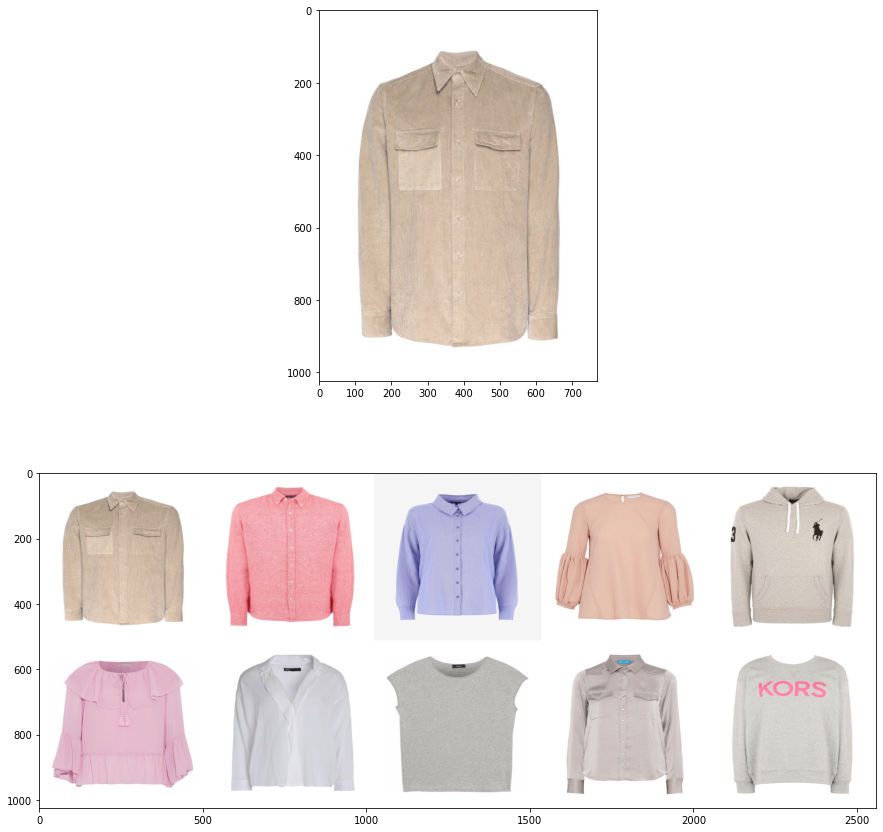

In [ ]:
# train / train
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 3166# Input Index for which images 
MAX_RESULTS = 10
print('Classe dell immagine:', index_dict['class'][queryIdx])

# per poter caricare anche dati salvati nel file .pkl
queryFeatures = index_dict['features'][queryIdx]
#queryFeatures = latent_features[queryIdx]

results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j, '\tclass', index_dict['class'][j])
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

### Su dati di test !!!

In [ ]:
test_set.image_path.values

In [ ]:
# scelgo l'immagine della query tra quelle di TEST !!!
testimages = test_set.image_path.values
testimages.shape

(1476,)

In [ ]:
test_set

In [ ]:
test_set= test_set.reset_index()
test_set= test_set.drop(columns='index')
test_set

,image_path,class
0,/content/drive/MyDrive/Computer Vision Project...,64
1,/content/drive/MyDrive/Computer Vision Project...,42
2,/content/drive/MyDrive/Computer Vision Project...,78
3,/content/drive/MyDrive/Computer Vision Project...,77
4,/content/drive/MyDrive/Computer Vision Project...,47
...,...,...
1471,/content/drive/MyDrive/Computer Vision Project...,11
1472,/content/drive/MyDrive/Computer Vision Project...,23
1473,/content/drive/MyDrive/Computer Vision Project...,11
1474,/content/drive/MyDrive/Computer Vision Project...,82


Parte finale di 'test_latent_features' piena di zeri, non vado a lavorare su quella.

In [ ]:
# da eseguire
def get_latent_features(images, transformations): 
    # use TEST dimension

    latent_features = np.zeros((1476,8,42,42)) #AE_1
    #latent_features = np.zeros((1476,256, 14, 14)) #Conv_layers
    #latent_features = np.zeros((1476,512,16,16)) # RESNET18 512, 16, 16
    #latent_features = np.zeros((4738,256,16,16)) # v_2
    
    for i,image in enumerate(tqdm(images)): # sui 5900 elementi
        tensor = transformations(Image.open(image)).to(device)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        #latent_features[i] = model(tensor.unsqueeze(0)).cpu().detach().numpy() # RESNET18
        
    del tensor
    gc.collect()
    return latent_features

In [ ]:
# lo calcolo, così posso rispondere per ogni immagine di test
test_latent_features = get_latent_features(testimages, transformations)

  0%|          | 0/1476 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 1476/1476 [18:01<00:00,  1.36it/s]


In [ ]:
# ATTENZIONE: NO
indexes = list(range(0, 1476))
feature_dict = dict(zip(indexes,test_latent_features))
index_dict_test = {'indexes':indexes,'features':test_latent_features, 'class': test_set['class'].values}

In [ ]:
index_dict_test

Salvare e leggere le features delle immagini di test che si calcolano

In [ ]:
# nome file dove salvare le features delle immagini
with open('features_test_ae2_50ep.pkl', 'wb') as fp:
    pickle.dump(index_dict_test, fp)

In [ ]:
with open ('/content/drive/MyDrive/Computer Vision Project/Code/Retrieval/Checkpoints/ConvAutoencoder/outfile_test-clothes_conv_autoencoder_6ep.pkl', 'rb') as fp:
    test_latent_features = pickle.load(fp)

In [ ]:
test_latent_features.shape
# dim. = 3267 ma considero solo i primi 817, gli altri pieni di 0!

(1476, 256, 14, 14)

In [ ]:
# train / test
'''
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
MAX_RESULTS = 10
queryIdx = 5 #12
print('Classe dell immagine:', index_dict['class'][queryIdx])

queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j, '\tclass', index_dict['class'][j])
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(testimages[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)
'''

Classe dell immagine: 78
10 	class 78
1015 	class 78
1365 	class 58
678 	class 58
462 	class 78
262 	class 58
1424 	class 78
182 	class 78
271 	class 58
890 	class 58


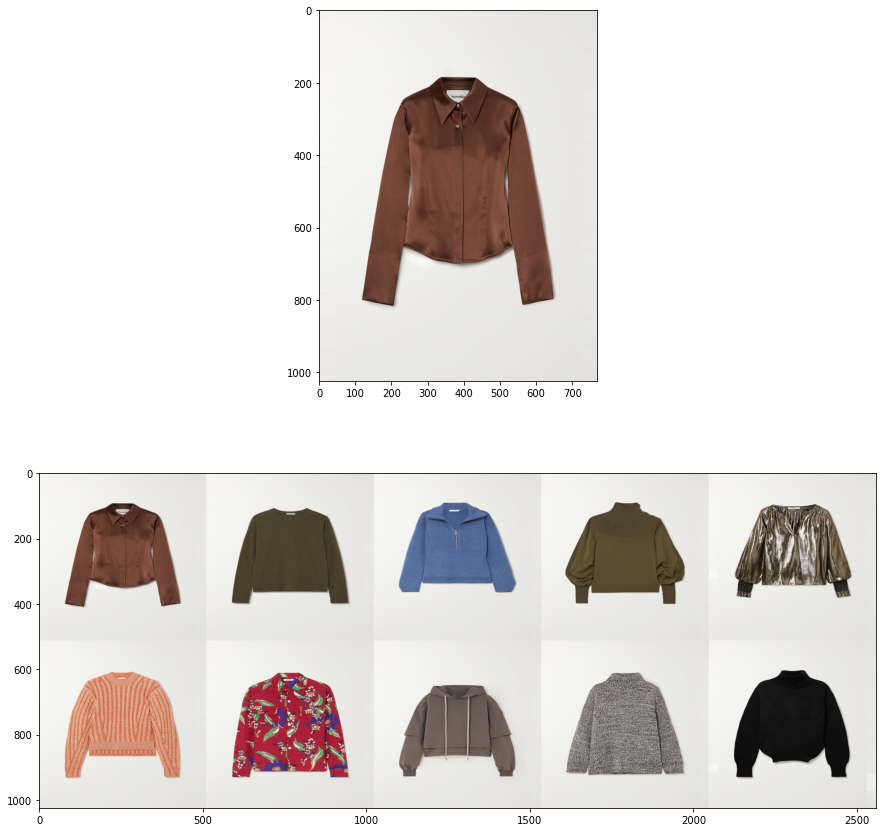

In [ ]:
# test / test   OK!!!
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
MAX_RESULTS = 10
queryIdx = 10 #12
print('Classe dell immagine:', index_dict_test['class'][queryIdx])

queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict_test, maxResults=MAX_RESULTS) 
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(testimages[j]))
    print(j, '\tclass', index_dict_test['class'][j])
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(testimages[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

Controllare se il dataset che si sta utilizzando è ordinato sugli indici

## Metriche

In [ ]:
test_set= test_set.reset_index()

In [ ]:
test_set= test_set.drop(columns='level_0')

In [ ]:
#test_set= test_set.drop(columns='level_0')
test_set= test_set.drop(columns='index')

In [ ]:
test_set

,image_path,class
0,/content/drive/MyDrive/Computer Vision Project...,78
1,/content/drive/MyDrive/Computer Vision Project...,78
2,/content/drive/MyDrive/Computer Vision Project...,30
3,/content/drive/MyDrive/Computer Vision Project...,78
4,/content/drive/MyDrive/Computer Vision Project...,47
...,...,...
1471,/content/drive/MyDrive/Computer Vision Project...,38
1472,/content/drive/MyDrive/Computer Vision Project...,49
1473,/content/drive/MyDrive/Computer Vision Project...,49
1474,/content/drive/MyDrive/Computer Vision Project...,38


In [ ]:
'''
labels= test_set.iloc[:,1]
labels
'''
test_set['class'][0]

64

In [ ]:
labels= []
for i in range(test_set.shape[0]):
  labels.append(test_set.iloc[i,1])

# labels[n]=2
labels[0]

64

In [ ]:
np.unique(labels)

In [ ]:
test_set['class'].index

RangeIndex(start=0, stop=1476, step=1)

In [ ]:
test_set['class'][1] # non presente, diversi?

18

!!!

Blocco per la valutazione delle metriche.

Cambiare il valore di 'MAX_RESULTS' per valutare una delle tre diverse accuracy usate.

In [ ]:
# test_latent_features, index_dict_test                 AAAAAAAAA

# TOP-3 ACCURACY
MAX_RESULTS = 10
top_3=[]
tot=0
corr=0

for i in range(len(test_set)): #170
  #truth_label= labels[i]
  print('true', test_set['class'][i])
  queryFeatures = test_latent_features[i]
  results = perform_search(queryFeatures, index_dict_test, maxResults=MAX_RESULTS) # index_dict
  # i primi 3 valori / indici che performano la misura di similarità 
  # ritorna il valore della misura di similarità e valore dell'indice
  
  # loop over the results
  top_3= []
  for (d, j) in results:
      top_3.append(j)
      print(j)
  print('\n')
  #print('?', labels[top_3[2]]) # non posizione, ma colonna INDICE del dataset
  
  # 3 indici dei max
  cnt=0
  for k in range(MAX_RESULTS):
    if i != top_3[k]: # 
      if test_set['class'][i] == (test_set['class'][top_3[k]]) and cnt==0: # dataset_train o test_set
        corr += 1
        cnt=1
  tot += 1
  
  
# 1 ce ne deve essere per essere ok

Output streaming troncato alle ultime 5000 righe.
542
1118
282
896
379
1212


true 47
1092
788
56
666
777
151
1141
634
335
538


true 10
1093
168
14
31
954
35
220
597
884
573


true 78
1094
2
438
1462
1102
220
1096
133
1354
14


true 47
1095
193
48
634
231
862
1324
690
643
600


true 23
1096
133
389
665
633
1462
653
128
1102
708


true 75
1097
144
464
1102
1462
1111
688
133
31
1153


true 78
1098
784
267
1031
1048
687
358
661
406
2


true 78
1099
17
570
1015
876
125
1371
85
974
1186


true 11
1100
86
149
656
614
353
440
1341
1270
1260


true 12
1101
417
1270
279
440
1472
380
87
927
1144


true 66
1102
1215
871
748
128
894
1096
508
1462
31


true 9
1103
366
423
314
508
1420
894
977
722
555


true 68
1104
707
442
812
1228
1342
197
947
745
564


true 77
1105
225
883
987
1030
247
734
1027
655
896


true 49
1106
909
1371
388
823
876
436
906
223
109


true 47
1107
17
1099
751
1220
628
1281
125
704
826


true 2
1108
544
199
559
865
931
1382
43
792
1402


true 47
1109
1275
573
158
695
894
764


In [ ]:
accuracy= (corr/tot)
print('Accuracy TOP-3:', accuracy)

Accuracy TOP-3: 0.8387533875338753


In [ ]:
len(top_3)

3

OK !!!

Fine parte.

In [ ]:
index_dict_test

In [ ]:
test_latent_features

I dizionari (INDEX_DICR e INDEX_DICT_TEST) sono, per costruzione, ordinati con gli elementi degli indici.

In [ ]:
dataset_train

,image_path,class
0,/content/drive/MyDrive/Computer Vision Project...,42
1,/content/drive/MyDrive/Computer Vision Project...,22
2,/content/drive/MyDrive/Computer Vision Project...,64
3,/content/drive/MyDrive/Computer Vision Project...,30
4,/content/drive/MyDrive/Computer Vision Project...,69
...,...,...
5895,/content/drive/MyDrive/Computer Vision Project...,49
5896,/content/drive/MyDrive/Computer Vision Project...,11
5897,/content/drive/MyDrive/Computer Vision Project...,46
5898,/content/drive/MyDrive/Computer Vision Project...,78


In [ ]:
# dataset_train: vedere com'è E ORDINARLO SUGLI INDICI PER AVERE LE CLASSI GIUSTE
dataset_train= dataset_train.reset_index()
dataset_train= dataset_train.drop(columns='index')

In [ ]:
dataset_train['class'][1634]

78

In [ ]:
len(test_latent_features)

5900

In [ ]:
# prova 2 con TOP3-ACCURACY OK
'''
prima mettere in ordine con il reset_index la parte del 'dataset_train' e poi come sopra
'''

MAX_RESULTS = 10
top_3=[]
tot=0
corr=0

for i in range(len(test_set)): #dataset_train
  #truth_label= labels[i]
  print('true class:', dataset_train['class'][i])
  queryFeatures = test_latent_features[i] #latent_features, test_latent_features
  results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS) # index_dict
  # i primi 3 valori / indici che performano la misura di similarità 
  # ritorna il valore della misura di similarità e valore dell'indice
  
  # loop over the results
  top_3=[]
  for (d, j) in results:
      top_3.append(j)
      print(j)
  print('\n')
  #print('?', labels[top_3[2]]) # non posizione, ma colonna INDICE del dataset
  
  # 3 indici dei max
  cnt=0
  for k in range(MAX_RESULTS):
    if i != top_3[k]: # 
      if dataset_train['class'][i] == (dataset_train['class'][top_3[k]]) and cnt==0: # dataset_train o test_set
        corr += 1
        cnt=1
  tot += 1


In [ ]:
tot

In [ ]:
accuracy= (corr/tot)
print('Accuracy TOP-3, su tutti i dati:', accuracy)

results: (15.890712498341511, 4611)

rappresenta la distanza dalla query e l'indice dell'elemento co quella distanza. Mi interessa l'indice dell'elemento ma ordinando i valori della distanza con elemento della query.

## Valutare new image

Inserire nuova immagine esterna e valutare rispetto a quella

In [ ]:
new_transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            transforms.Resize((512,512))
        ])

In [ ]:
# usato solo il primo dei 4738
def new_extract(image, transformations):
  latent_features = np.zeros((1,8,42,42)) #v_1
  #latent_features = np.zeros((4738,256,16,16)) # v_2
  #latent_features = np.zeros((4738,256, 14, 14)) #Conv_layers

  tensor = transformations(Image.open(image)).to(device)
  latent_features= model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
  del tensor
  gc.collect()
  return latent_features

In [ ]:
dataset_train['image_path']

3264     /content/drive/MyDrive/Computer Vision Project...
14752    /content/drive/MyDrive/Computer Vision Project...
12155    /content/drive/MyDrive/Computer Vision Project...
4196     /content/drive/MyDrive/Computer Vision Project...
7188     /content/drive/MyDrive/Computer Vision Project...
                               ...                        
5462     /content/drive/MyDrive/Computer Vision Project...
4253     /content/drive/MyDrive/Computer Vision Project...
3824     /content/drive/MyDrive/Computer Vision Project...
11156    /content/drive/MyDrive/Computer Vision Project...
342      /content/drive/MyDrive/Computer Vision Project...
Name: image_path, Length: 5900, dtype: object

In [ ]:
# calcolare features, rispetto all'immagine inserita
new_image_path= '/content/drive/MyDrive/Computer Vision Project/Code/Dataset/Dataset-mezzo/images/11808037tr_0_e.jpg' 
new_image_path= dataset_train['image_path'][11156]

new_queryFeatures= new_extract(new_image_path, new_transformations)

41 	class 78
871 	class 6
739 	class 34
671 	class 23
939 	class 34
525 	class 34
1393 	class 78
578 	class 18
1002 	class 78
194 	class 34


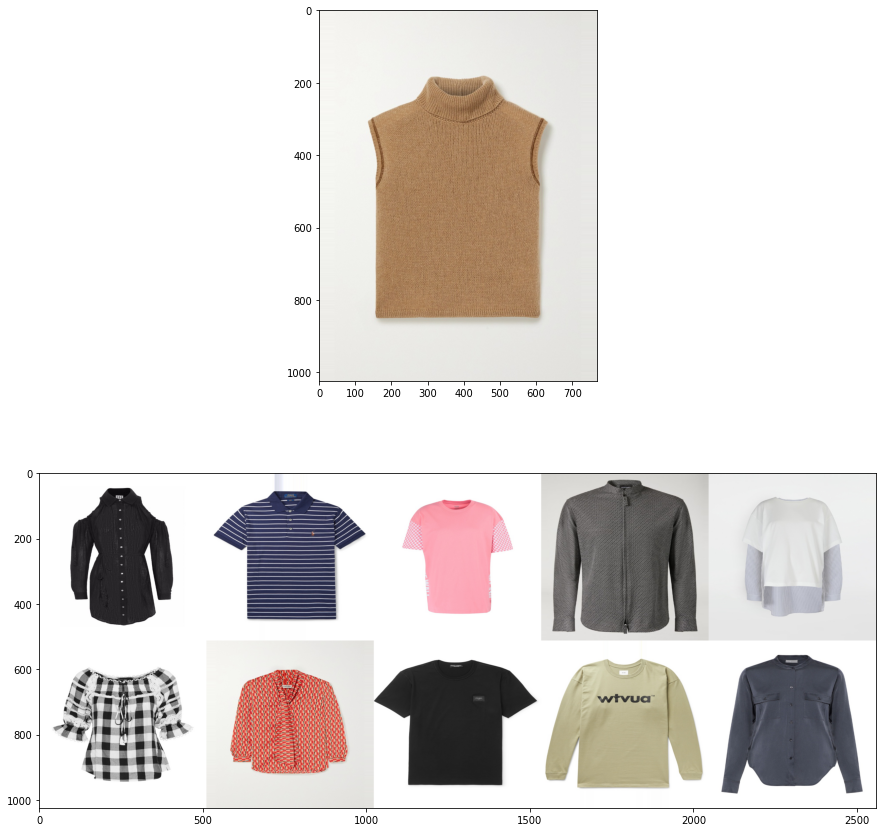

In [ ]:
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
MAX_RESULTS = 10

results = perform_search(new_queryFeatures, index_dict_test, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j, '\tclass', index_dict_test['class'][j])
    imgs.append(img)

# display the query image, da cambiare
ax[0].imshow(np.array(Image.open(new_image_path)))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

## Materiale non necessario

Prove, selezionando 2 TIPI di immagini diverse!

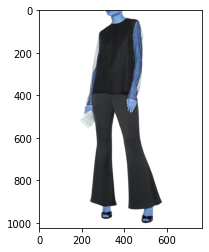

In [ ]:
im1=cv2.imread('/content/drive/MyDrive/Computer Vision Project/Code/Dataset/Dataset-mezzo/images/11619237ej_0_e.jpg')
'/content/drive/MyDrive/Computer Vision Project/Code/Dataset/Dataset-mezzo/images/11808037tr_0_e.jpg'
plt.imshow(im1)

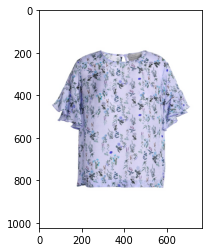

In [ ]:
im2=cv2.imread('/content/drive/MyDrive/Computer Vision Project/Code/Dataset/Dataset-mezzo/images/11808037tr_1_f.jpg')
plt.imshow(im2)

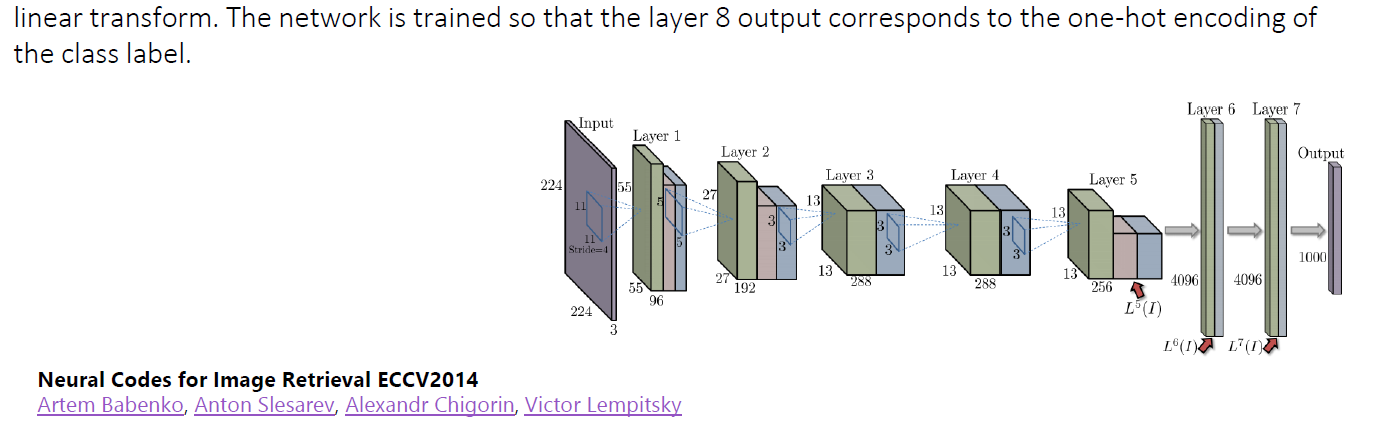